In [1]:
import arviz as az
import numpy as np

import pymc as pm
import aesara.tensor as at

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [8]:
n_categories = 4
init_nu = 1.0
x_shape = (85, 6)

X = np.stack(
    [
        np.ravel(
            np.random.permutation([0, 0, 1])[..., None] * np.random.permutation([-1, 1])
        )
        for _ in range(x_shape[0])
    ]
)

c = np.random.randint(n_categories, size=x_shape[0])
# w_k = np.random.rand(n_categories, x_shape[1])
# w_k /= w_k.sum(axis=1, keepdims=True)
# np.sum(np.log(w_k[c]) * X, axis=1)

In [3]:
p = np.asarray([5.0, 3.0, 2.0, 1.0])
p /= p.sum()
d = np.random.choice(np.arange(n_categories), size=x_shape[0], p=p) + 1
y = np.log(2 * d + 1)

In [4]:
with pm.Model() as m:
    a_0 = pm.LogNormal("a_0", mu=pm.math.log(init_nu), sigma=0.1, shape=(X.shape[1],))
    w_k = pm.Dirichlet("w_k", a=a_0, shape=(n_categories, X.shape[1]))
    act_out = at.sum(at.log(w_k[c]) * X, axis=1)
    out = pm.Normal("out", mu=act_out, sigma=0.1, observed=y)
    idata = pm.sample()
    idata.extend(pm.sample_posterior_predictive(idata))

az.plot_ppc(idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_0, w_k]
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 159 seconds.
/opt/miniconda3/envs/aesara-dev/lib/python3.9/site-packages/numba/core/dispatcher.py:241: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'ValueError(No function '__pyx_fuse_0pdtr' found in __pyx_capi__ of 'scipy.special.cython_special')'.
  entrypoints.init_all()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_0, log_w]
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.


<AxesSubplot:xlabel='out / out'>

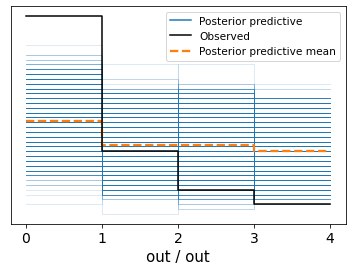

In [15]:
with pm.Model() as m2:
    a_0 = pm.Normal("a_0", mu=0., sigma=1, shape=X.shape[1])
    log_w = pm.Normal("log_w", mu=a_0, sigma=1, shape=(n_categories, X.shape[1]))
    log_p = at.sum(log_w * X[..., None, :], axis=-1)
    p = pm.math.softmax(log_p, axis=-1)
    out = pm.Categorical("out", p=p, observed=d-1)
    idata = pm.sample()
    idata.extend(pm.sample_posterior_predictive(idata))

az.plot_ppc(idata)